In [3]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [4]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io.gtfs_reader import importer
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel

if manual:
    %matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [5]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [6]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)

In [7]:
full_feed = importer.GtfsImporter(path=input_folder + r'/IDFM_gtfs.zip', dist_units='m') 
# downloaded from https://data.iledefrance-mobilites.fr/explore/dataset/offre-horaires-tc-gtfs-idf/table/

In [8]:
feed_r = full_feed.restrict(
    dates=['20200204'] # the dates must be within the feed start and end dates
)

In [9]:
time_range = ['07:00:00', '10:00:00'] #on peut limiter à la période de pointe
feed_t = feed_r.restrict(time_range=time_range)

In [10]:
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [11]:
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [12]:
feed = feed_s.copy()
feed.group_services()

In [13]:
feed.build_stop_clusters(distance_threshold=300)
feed.build_patterns(on='cluster_id')

In [14]:
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|████████████████████████████████████████████████████████████████████████████████| 423/423 [00:17<00:00, 24.80it/s]


In [15]:
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32631


In [16]:
feed_frequencies.links.head(1).T

,0
index,9
a,StopPoint:14:411
trip_id,098098001:DIRECT1_0
link_sequence,1
departure_time,26340.0
pickup_type,0
b,StopPoint:14:14977
arrival_time,27600.0
drop_off_type,0
time,1260.0


In [17]:
feed_frequencies.nodes.head(1)

,stop_id,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,cluster_id,geometry
315,StopArea:8738102,PORTE MAILLOT,NaN,NaN,NaN,1,NaN,NaN,187,POINT (2.28258 48.87812)


# rename route types

In [18]:
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

In [19]:
feed_frequencies.nodes.head(1)

,stop_id,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,cluster_id,geometry
315,StopArea:8738102,PORTE MAILLOT,NaN,NaN,NaN,1,NaN,NaN,187,POINT (2.28258 48.87812)


# export 

In [20]:
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
sm.links = feed_frequencies.links
sm.nodes = feed_frequencies.nodes#[['geometry', 'stop_id', 'stop_name', 'location_type']]
sm.zones = zones

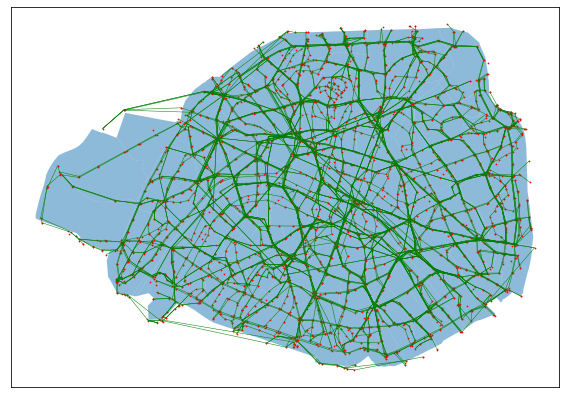

In [21]:
ax = sm.plot('zones', alpha=0.5, figsize=[17, 7])
ax = sm.plot('links', linewidth=0.5, color='green', ax=ax)
plot= sm.plot('nodes', markersize=0.5, color='red', ax=ax)

In [22]:
sm.to_json(input_folder + 'gtfs', only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|███████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.52it/s]


In [23]:
#import os
#os.environ['PATH'] += os.pathsep + os.path.expanduser('~\\Anaconda3\\envs\\quetzal_env\\Lib\\site-packages\\tables')
sys.path.insert(0, '~\\Anaconda3\\envs\\quetzal_env\\Lib\\site-packages\\tables')
#import tables
sm.to_zippedpickles(training_folder + r'model/{scen}/base'.format(scen=scenario))

zones: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 31.25it/s]


# END